In [ ]:
SOC 0 ~ 0.017로 나누자

In [ ]:
# step 0.01 transition matrix로는 안됨 -> 새로 만듦
# RPM에서 최적인 토크는 map에서 뽑음
# Action 1 : 엔진 On/Off (특정값 이상이면 ON)
# Action 2 : 엔진 토크를 높여줌

# Optimal policy가 여러 개 일수도
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724


In [ ]:
!pip install wandb
!wandb login --relogin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install fmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 13.4 MB/s eta 0:00:00


In [ ]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
import argparse
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras

from collections import deque
import numpy as np
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import scipy.signal
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import FloatTensor as FT

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

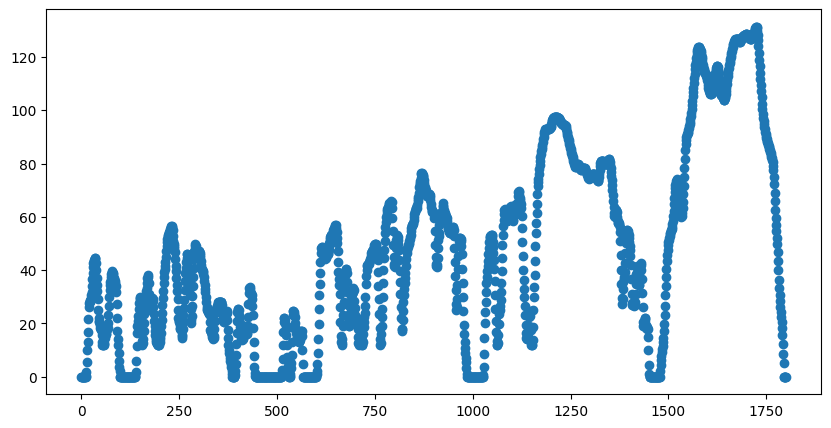

In [ ]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230711_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 1
soc_init = 67

# WLTP profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
    vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

EngLine = pd.read_csv('wltp_EngLine_rule_based_10Hz.csv')
EngLine = np.array(EngLine['EngLine'])
plt.figure(figsize = (10,5))
plt.scatter(vehicle_speed_profile[:,0],vehicle_speed_profile[:,1])

In [ ]:
max(vehicle_speed_profile[:,1])

131.3

In [ ]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init/5000
        self.soc_base = soc_init/5000
        self.state_init = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.state = np.array([self.soc_init, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2

        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')

    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init*5000
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))/5000
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['BSFC_g_kWh[1]'], self.vrs['Driver_sVeh_kph']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = 1 - 10000*(self.soc_init - soc) ** 2 - BSFC
        is_done = lambda time: time >= self.stop_time
        info = state[np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])]
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), info

    def reset(self):
        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.state = self.state_init
        self.time = self.start_time

        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']

        return self.state.reshape(1,-1)

DP

In [ ]:
# state data 생성
statelist = [[],[],[]]
start = time.time()
for ep in range(10000):
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  env.reset()
  done = False
  action = []
  for j in range(2):
      x = random.randint(1,2)
      act = random.random()*(-1)**x
      action.append(act)

  while done == False:
    # state 데이터 모으기
    s,r,done,_ = env.step(action)
    statelist[0].append(s[0][0])  # SOC
    statelist[1].append(s[0][1])  # BSFC
    # statelist[2].append(s[0][-1]) # vel
  if (ep+1)%100 ==0:
    print("i : ",ep,"/ time : ", time.time()-start)
    np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/statedata.npy', np.array(statelist))

KeyboardInterrupt: ignored

In [ ]:
# statedata를 기반으로 등개수 구간 10개 나눔
# SOC / Velocity -> 100개 state indexing
statedata = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/statedata.npy')
SOC_interval_n, vel_interval_n = 10,9
BSFC_interval_n = 9
cut_SOC = pd.qcut(statedata[0],SOC_interval_n)
# cut_BSFC = pd.qcut(statedata_[1][np.nonzero(statedata_[1])],BSFC_interval_n) # 0인 데이터가 많아서 0을 빼고 cut
cut_vel = pd.qcut(statedata[2][np.nonzero(statedata[2])],vel_interval_n) # 0인 데이터가 많아서 0을 빼고 cut

# 0 데이터가 많아서 제외
# print(1 - len(np.nonzero(statedata_[1])[0])/len(statedata_[0]))
# print(1 - len(np.nonzero(statedata_[2])[0])/len(statedata_[0]))

print("------------------------------------------------------------------------------")
print("SOC interval")
print(cut_SOC.describe())
# print("------------------------------------------------------------------------------")
# print("BSFC interval")
# print(cut_BSFC.describe())
print("------------------------------------------------------------------------------")
print("Velocity interval")
print(cut_vel.describe())
print(len(statedata[0])-len(np.nonzero(statedata[2])[0]),1 - len(np.nonzero(statedata[2])[0])/len(statedata[0]))

------------------------------------------------------------------------------
SOC interval
                    counts  freqs
categories                       
(0.00288, 0.00562]  180000    0.1
(0.00562, 0.00628]  180000    0.1
(0.00628, 0.00672]  180000    0.1
(0.00672, 0.0072]   180000    0.1
(0.0072, 0.00808]   180000    0.1
(0.00808, 0.01]     180000    0.1
(0.01, 0.0111]      180000    0.1
(0.0111, 0.0118]    180000    0.1
(0.0118, 0.0128]    180000    0.1
(0.0128, 0.0143]    180000    0.1
------------------------------------------------------------------------------
Velocity interval
                     counts     freqs
categories                           
(-0.00096, 0.00318]  176000  0.112388
(0.00318, 0.00466]   173000  0.110473
(0.00466, 0.0064]    174000  0.111111
(0.0064, 0.00869]    173000  0.110473
(0.00869, 0.0106]    174000  0.111111
(0.0106, 0.0126]     175000  0.111750
(0.0126, 0.0158]     173000  0.110473
(0.0158, 0.0208]     174000  0.111111
(0.0208, 0.0263]     17

In [ ]:
state_num = 100
action_num = 11

# action indexing
action_grid = []
for i in np.linspace(-1,1,action_num):
  for j in np.linspace(-1,1,action_num):
    action_grid.append([i,j])

# state indexing
def state_idx(soc, vel):
  x = 0
  if soc > cut_SOC.categories[-1].right:
    x += SOC_interval_n-1

  for i in range(SOC_interval_n):
    if soc in cut_SOC.categories[i]:
      x += i
      break

  if vel > cut_vel.categories[-1].right:
      x += vel_interval_n*10

  if vel != 0:
    for j in range(vel_interval_n):
      if vel in cut_vel.categories[j]:
        x += (j+1)*10
        break
  return x


# Transition probabilty
def get_prob(oldstate, action, buffer):
  action_prob = []
  for state in range(state_num):
    if buffer[oldstate][action][state] != 0:
      prob = buffer[oldstate][action][state]/np.sum(buffer[oldstate][action])
      action_prob.append([state, prob])
  return action_prob

# # value iteration
# def value_iteration(iter_num, t_mtx, r_mtx, post_value_table = np.ones(100)*(-100), state_num=100, dis = 0.99):
#   start = time.time()
#   next_value_table = np.ones(100)*(-100)
#   iteration = 0
#   # for iteration in range(iter_num):
#   while True:
#     for curr_state in range(state_num):
#       valuelist = []
#       for action in range(len(action_grid)):
#         if len(get_prob(curr_state,action,t_mtx)) != 0 :
#           value = 0
#           for next_state, prob in get_prob(curr_state, action, t_mtx):
#             value += prob*(r_mtx[curr_state][action][0] + dis*post_value_table[next_state])
#           valuelist.append(value)
#       if len(valuelist) != 0:
#         next_value_table[curr_state] = max(valuelist)
#     print(iteration)
#     print(next_value_table)
#     # if (iteration+1) % 500 == 0:
#     #   print('------------------------------------------------------------------')
#     #   print('iteration : ',iteration+1)
#     #   print('time      : ',time.time()-start)
#     #   # np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/table_.npy', next_value_table)
#     #   print(next_value_table-post_value_table)

#     if np.max(np.abs(next_value_table-post_value_table)) < 0.001:
#       print('iteration : ', iteration+1)
#       print('convergence!')
#       print(post_value_table - next_value_table)
#       return next_value_table

#     iteration += 1
#     post_value_table = next_value_table

#   return next_value_table

# value iteration
def value_iteration(iter_num, t_mtx, r_mtx, post_value_table = np.zeros(100), state_num=100, dis = 0.99):
  start = time.time()
  next_value_table = np.zeros(100)
  iteration = 0
  while True:
    for curr_state in range(state_num):
      valuelist = []
      for action in range(len(action_grid)):
        value = 0
        for next_state, prob in get_prob(curr_state, action, t_mtx):
          value += prob*(r_mtx[curr_state][action][0] + dis*post_value_table[next_state])
        valuelist.append(value)
      next_value_table[curr_state] = np.max(valuelist)
    print('------------------------------------------------------------------')
    print('iteration : ', iteration)
    print(next_value_table)
    print(post_value_table)
    print(next_value_table-post_value_table)

    # convergence
    if np.max(np.abs(next_value_table-post_value_table)) < 0.1:
      print('convergence!')
      print(next_value_table - post_value_table)
      return next_value_table # value function for all state

    post_value_table = next_value_table.copy()
    iteration += 1

# deterministic policy based on valuetable
def get_policy(oldstate, buffer, valuetable):
  valuelist = {}
  actionlist = []
  for i in range(len(action_grid)):
    value = 0
    for next_state, prob in get_prob(oldstate,i,buffer):
      value += prob*valuetable[next_state]
    valuelist[i] = value
  valuelist = sorted(valuelist.items(), key=lambda x : x[1], reverse=True)
  if valuelist[0].keys == 0:
    return valuelist
  else:
    return valuelist[:3]

# stochastic policy based on valuetable
def get_policy_dist(oldstate, buffer, valuetable, T):
  valuelist = []
  for i in range(len(action_grid)):
    value = 0
    for next_state, prob in get_prob(oldstate,i,buffer):
      value += prob*valuetable[next_state]
    # valuelist.append(np.exp(value/T))
    valuelist.append(value)

  value_sum = np.sum(valuelist)
  return [v/value_sum for v in valuelist]

In [ ]:
# transition matrix 생성
# 속도가 정해져있음 (속도, SOC, action)
# 8000 + 9000 + 8000 + 10000 + 4000 + 9000 = 50000
state_num = 100
action_num = len(action_grid)
# transition_mtx = np.zeros([state_num,action_num,state_num])
reward_list = [[[0] for i in range(action_num)] for j in range(state_num)]

transition_mtx = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/transition_mtx.npy')
reward_list = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/reward_mtx.npy')
reward_list = reward_list.tolist()

start = time.time()
for ep in range(2000):
  env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
  env.reset()
  done = False
  k = 0

  while done == False:
    idx = random.randint(0,action_num-1)
    s,r,done,_ = env.step(action_grid[idx])
    state = state_idx(s[0][0],s[0][-1])
    reward_list[state][idx].append(r)
    if k > 0:
      transition_mtx[old][idx][state] += 1
    old = state
    k+= 1
  if (ep+1)%1000==0:
    reward_array = [[[np.mean(i)] for i in reward_list[j]] for j in range(state_num)]
    print('----------------------------------------------------------------------------------')
    print('episode :', (ep+1), ' saved!')
    print('time    :', (time.time()-start)/60)
    print(sum(sum(sum(transition_mtx))))
    np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/reward_mtx.npy', np.array(reward_array))
    np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/transition_mtx.npy', transition_mtx)

----------------------------------------------------------------------------------
episode : 1000  saved!
time    : 25.40159403483073
88151000.0
----------------------------------------------------------------------------------
episode : 2000  saved!
time    : 50.92183629671732
89950000.0


In [ ]:
trans_mtx =  np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/transition_mtx.npy')
reward_mtx = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/reward_mtx.npy')
table = value_iteration(10000, trans_mtx, reward_m tx)
np.save('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/WOW.npy', table)

------------------------------------------------------------------
iteration :  0
[375.01082656 457.72620589 525.35062292 587.3579062  661.6871578
 765.81574036 932.87775406 960.11313629 984.67365829 999.46935435
 354.78448222 448.68186747 520.86047714 579.31233586 655.3684808
 848.26028569 922.90634303 957.49855944 985.68522869 997.06646326
 343.92612686 445.91664162 519.04907492 578.28974852 661.5593736
 840.66609644 915.98134817 958.28374824 982.7332607  993.50608752
 341.74816676 446.3280106  518.04524806 575.13469609 649.71916609
 828.40972357 912.84168962 959.24366549 983.10608425 991.16360561
 330.23106225 437.84762722 512.32498746 568.2082635  651.88470376
 818.48394459 910.12091708 960.29662126 979.37533645 988.75868363
 334.31605278 446.81724104 518.6972848  577.09658287 659.42768961
 811.4008185  904.68656566 955.0197273  966.99204453 991.2390584
 312.69027306 435.62117214 515.25939124 574.43532365 651.69294862
 760.76872577 904.79494615 965.54534054 981.38236697 996.7266557

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-259-2b856aa1f989>", line 3, in <cell line: 3>
    table = value_iteration(10000, trans_mtx, reward_mtx)
  File "<ipython-input-258-4ff163154b41>", line 95, in value_iteration
    for next_state, prob in get_prob(curr_state, action, t_mtx):
  File "<ipython-input-258-4ff163154b41>", line 42, in get_prob
    if buffer[oldstate][action][state] != 0:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (

In [ ]:
trans_mtx =  np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/transition_mtx.npy')
reward_mtx = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/reward_mtx.npy')
table = np.load('/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0724/DP1123/1125/valuetable.npy')

policy_deter = {}
policy_stoc = {}

for state in range(100):
  policy_deter[state] = get_policy(state, trans_mtx, table)
  policy_stoc[state] = get_policy_dist(state, trans_mtx, table, 0.1)

AttributeError: ignored

In [ ]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
s = env.reset()
done = False
i = 0
policy_dp = []
policy_idx = []
s1list = []
s2list = []
s3list = []
statelist = []
reward = 0
actionidx = 0

while done == False:
  state = state_idx(s[0][0],s[0][-1])
  print(state)

  # Stochastic
  # actionidx = np.random.choice(np.arange(0,len(action_grid)),p=policy_stoc[state])

  # Deterministic
  # policy_list = policy[state]
  # if len(policy_list) == 1:
  #   actionidx = policy_list[0]
  # else:
  #   actionidx = policy_list[np.argmin(np.abs(np.array(policy_list)-actionidx))] # 이전 action에서 최대한 바뀌지 않도록

  # s,r,done,_ = env.step(action_grid[actionidx])
  s,r,done,_ = env.step([0.0,0.0])

  statelist.append(state)
  s1list.append(s[0][0])
  s2list.append(s[0][1])
  s3list.append(s[0][-1])
  policy_idx.append(actionidx)
  policy_dp.append(action_grid[actionidx])
  i += 1
  reward += r

print('-----------------------------------------------------------------------')
print('episodic reward       :',reward)

9
9
9
9
9
9
9
9
9
9
9
9
9
19
19
19
19
19
29
29
39
39
39
39
39
39
39
39
49
49
49
49
49
49
59
59
59
59
49
49
49
49
49
39
39
29
29
29
29
29
29
29
29
19
19
19
19
19
19
19
19
19
19
19
29
29
29
29
29
29
29
39
39
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
49
39
39
29
29
19
19
19
19
19
19
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
19
19
19
19
29
29
29
29
29
39
39
39
39
39
39
29
29
19
19
19
19
29
29
39
39
39
39
39
49
49
49
49
49
49
49
39
39
39
39
39
39
39
39
39
39
39
39
39
29
29
29
19
19
19
19
19
19
19
19
19
19
19
19
19
19
29
29
29
39
39
39
39
49
49
49
49
49
49
59
59
59
59
59
59
69
69
69
69
69
69
69
69
69
69
69
69
59
59
59
59
59
59
59
49
49
49
49
49
39
39
29
29
29
29
29
29
29
29
19
19
19
29
29
29
39
39
49
49
49
49
49
59
59
59
59
59
59
49
49
49
39
39
29
29
29
39
39
49
49
49
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
49
49
49
49
49
49
49
49
49
49
49
49
39
39
39
39
39
39
39
39
39
39
39
29
29
29
29
29
19
19
19
19
19
19
19
29
29
39
39
39
39
39
39
39
39

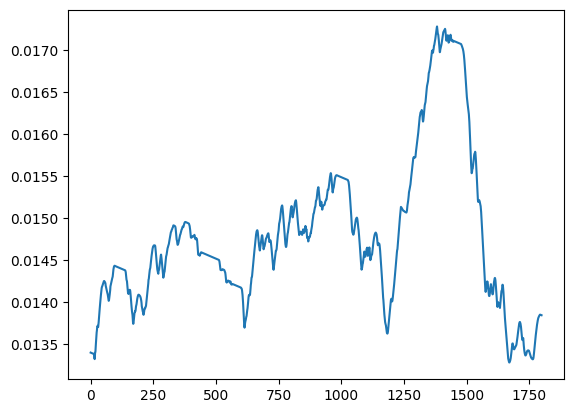

In [ ]:
s1list_ = [soc*5000 for soc in s1list]
plt.plot(s1list)
# print(max(s1list))
# 0.018/0.001

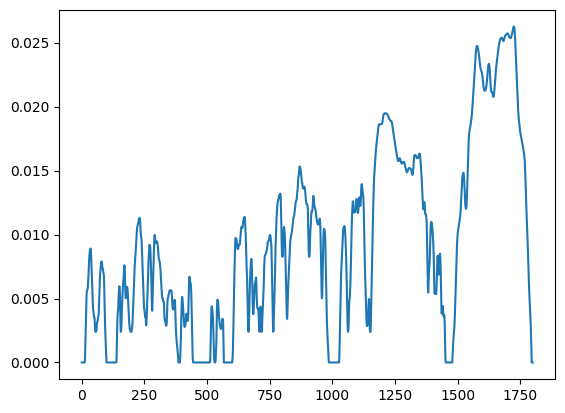

In [ ]:
plt.plot(s3list)

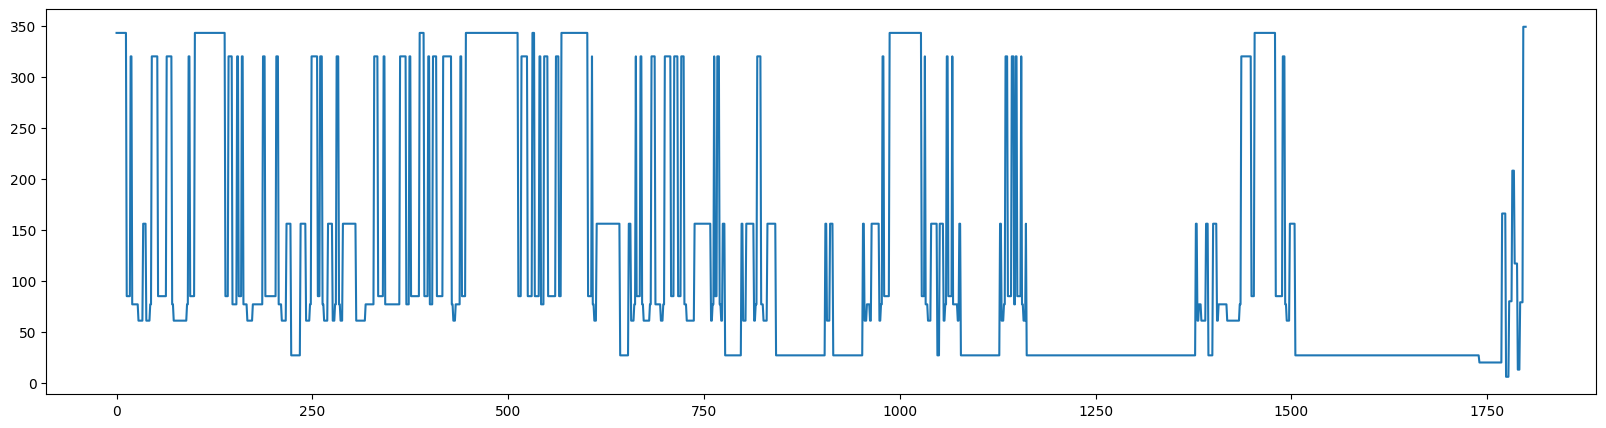

In [ ]:
plt.figure(figsize = (20,5))
policy_arr = np.array(policy_dp)
# plt.plot(policy_arr[:,1])
# plt.plot(policy_arr[:,0])
plt.plot(policy_idx)

In [ ]:
# WLTP에 대해서 하고 policy reward 다 비교하는 표 만들어보기
# DP class 객체화 -> 다른 cycle에 적용하기